Assignment 2: Linear Regression, Logistic Regression and K-NN in Heart  Disease Data

Use of AI Statemnt

ChatGPT was used to help fix errors and clarify concepts

other references: https://scikit-learn.org/stable/index.html


In [109]:
#load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet,LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV



In [110]:
#open data as Data Frame
data = pd.read_csv('../Data/heart_disease_uci.csv')

In [111]:
print(data.columns)

Index(['age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')


In [112]:
 # data cleaning
data = data.loc[:, data.isnull().mean() < 0.25].copy() 
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns
# Fill missing values
# For numerical columns, fill with mean; for categorical columns, fill with mode
for col in numerical_cols:
       
    data[col] = data[col].fillna(data[col].mean()) 
for col in categorical_cols:
    data[col] = data[col].fillna(data[col].mode()[0])
# Convert categorical variables to numerical using one-hot encoding
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)



Linear Regression Using ElasticNet to Predict Cholestoral

In [113]:
#define features and target variable
features = ['age','sex','cp','trestbps','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']
X = data.drop(columns=['chol', 'num'])  # Features excluding 'chol' and 'num'
y = data['chol']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#normalize the data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

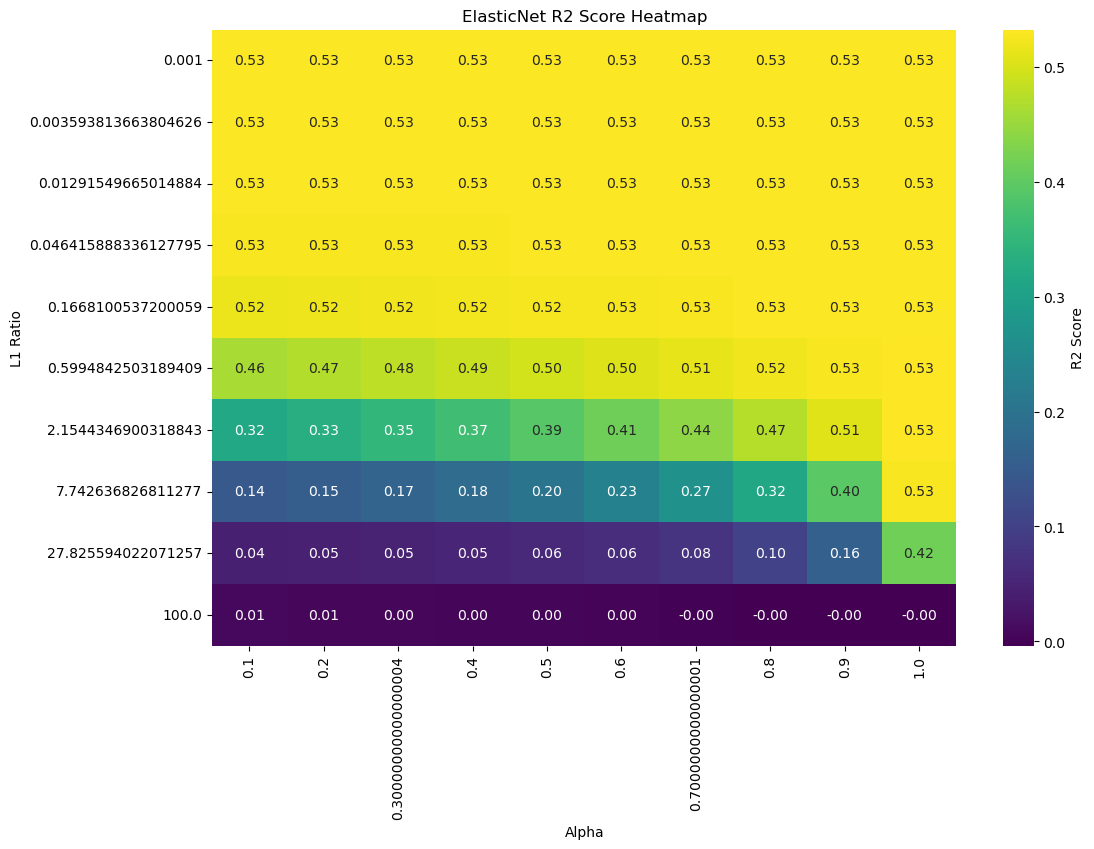

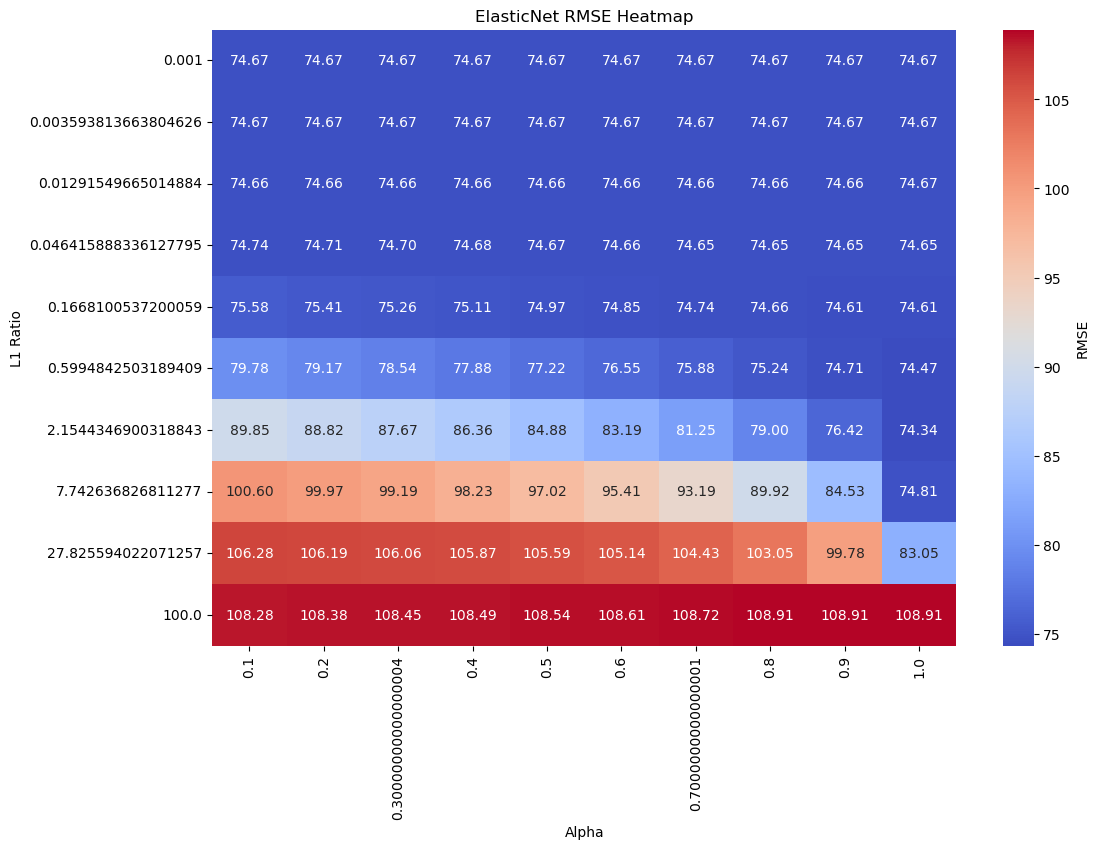

Best parameters based on R2 score: alpha        2.154435
l1_ratio     1.000000
r2_score     0.532310
rmse        74.344897
Name: 69, dtype: float64
Best parameters based on RMSE: alpha        2.154435
l1_ratio     1.000000
r2_score     0.532310
rmse        74.344897
Name: 69, dtype: float64


In [ ]:
alpha_values = np.logspace(-3, 2, 10) # Range of alpha values for ElasticNet with a logarithmic scale
l1_ratios = np.linspace(0.1, 1, 10) #range of l1_ratio values for ElasticNet

alpha_list= []
l1_list = []
r2_list = []
rmse_list = []

for a in alpha_values:
    for l1 in l1_ratios:
        # Create and fit the ElasticNet model
        model = ElasticNet(alpha=a, l1_ratio=l1, random_state=42)
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        rmse = np.sqrt( mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        alpha_list.append(a)
        l1_list.append(l1)
        r2_list.append(r2)
        rmse_list.append(rmse)    

# Create a DataFrame for heatmap data
heatmap_data = pd.DataFrame({
    'alpha': alpha_list,
    'l1_ratio': l1_list,
    'r2_score': r2_list,
    'rmse': rmse_list
})

#generate heatmaps for R2 score and RMSE
heatmap_data_r2 = heatmap_data.pivot(index='alpha', columns='l1_ratio', values='r2_score')
heatmap_data_rmse = heatmap_data.pivot(index='alpha', columns='l1_ratio', values='rmse')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_r2, annot=True, fmt=".2f", cmap='viridis', cbar_kws={'label': 'R2 Score'}) 
plt.xlabel("Alpha")
plt.ylabel("L1 Ratio")
plt.title("ElasticNet R2 Score Heatmap")
plt.show()   

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_rmse, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'RMSE'}, ) 
plt.xlabel("Alpha")
plt.ylabel("L1 Ratio")
plt.title("ElasticNet RMSE Heatmap")
plt.show()  

# Find the best parameters based on R2 score and RMSE
best_r2_index = heatmap_data.loc[heatmap_data['r2_score'].idxmax()]
best_rmse_index = heatmap_data.loc[heatmap_data['rmse'].idxmin()]
print("Best parameters based on R2 score:", best_r2_index)
print("Best parameters based on RMSE:", best_rmse_index) 

Classification Models to Predict the Presence of Heart Disease

In [115]:
#defining features and target
features = ['age','sex','cp','trestbps','fbs','chol','restecg','thalach','exang','oldpeak','slope','ca','thal']
X = data.drop(columns=['num'])  # Features excluding target
#code target variable into binary values
data['heart_disease'] = data['num'].apply(lambda x: 1 if x > 0 else 0)
y = data['heart_disease']  # Target variable
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [116]:
data.head()

,age,trestbps,chol,thalch,oldpeak,num,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,heart_disease
0,63,145.0,233.0,150.0,2.3,0,True,False,False,False,False,False,True,True,False,False,False,0
1,67,160.0,286.0,108.0,1.5,2,True,False,False,False,False,False,False,False,False,False,True,1
2,67,120.0,229.0,129.0,2.6,1,True,False,False,False,False,False,False,False,False,False,True,1
3,37,130.0,250.0,187.0,3.5,0,True,False,False,False,False,True,False,False,True,False,False,0
4,41,130.0,204.0,172.0,1.4,0,False,False,False,False,True,False,False,False,False,False,False,0


Logistic Regression

Best Combined Model: newton-cg with L2 penalty


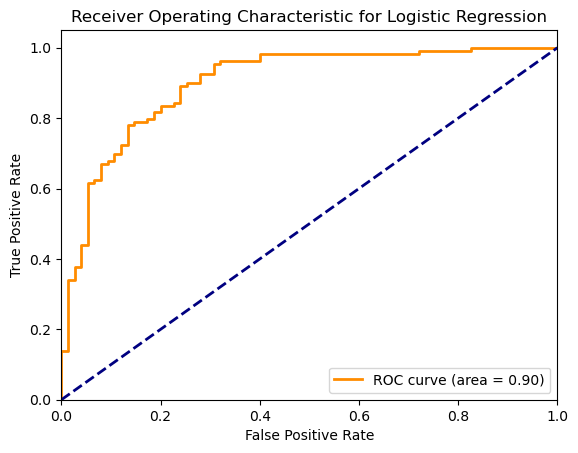

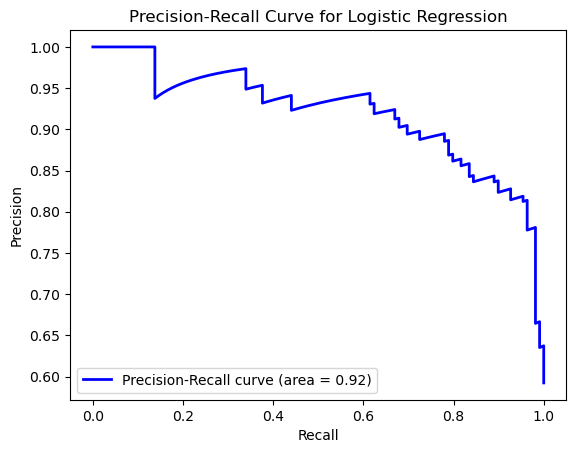

In [ ]:
#Create the Logistic Regression model and tuning hyperparameters
#Penalties for Logistic Regression
penalties = ['l1', 'l2', 'elasticnet', 'none']
#Solvers for Logistic Regression
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
#all penalties will not work with all solvers, L2 penalty is the default and works with all solvers, while L1 and ElasticNet work with 'liblinear' and 'saga' solvers.

#tuning solvers with L2 penalty
L2_f1_scores = []
L2_accuracies = []
L2_solvers = []
for solver in solvers:
    

    model = LogisticRegression(penalty='l2', solver=solver, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    L2_f1_scores.append(f1)
    L2_accuracies.append(accuracy)
    L2_solvers.append(solver)

#L1 penalty with 'liblinear' and 'saga' solvers
L1_f1_scores = []   
L1_accuracies = []
L1_solvers = [] 
for solver in ['liblinear', 'saga']:
    
    model = LogisticRegression(penalty='l1', solver=solver, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    L1_f1_scores.append(f1)
    L1_accuracies.append(accuracy)
    L1_solvers.append(solver)

#ElasticNet penalty with 'saga' solver

elasticnet_solvers = ['saga']
model = LogisticRegression(penalty='elasticnet', solver='saga',l1_ratio=0.5, max_iter=1000, random_state=42)
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
elasticnet_f1_scores = f1_score(y_test, y_pred)
elasticnet_accuracies = accuracy_score(y_test, y_pred)    
      
# Create a DataFrame to summarize the results
results = pd.DataFrame({
    'Solver': L2_solvers + L1_solvers + elasticnet_solvers,
    'Penalty': ['L2'] * len(L2_solvers) + ['L1'] * len(L1_solvers) + ['ElasticNet'],
    'F1 Score': L2_f1_scores + L1_f1_scores + [elasticnet_f1_scores],
    'Accuracy': L2_accuracies + L1_accuracies + [elasticnet_accuracies]
})

#find the best model based on Accuracy
best_combo = results.loc[results['Accuracy'].idxmax()]
print("Best Combined Model:", best_combo['Solver'], "with", best_combo['Penalty'], "penalty")
best_model = LogisticRegression(
    penalty=best_combo['Penalty'].lower(),
    solver=best_combo['Solver'],
    l1_ratio=0.5 if best_combo['Penalty'] == 'ElasticNet' else None,
    max_iter=1000,
    random_state=42
)
# Fit the best model
best_model.fit(X_train, y_train)
y_scores = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and PR area
precision, recall, _ = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.legend(loc='lower left')
plt.show()


Best parameters for k-NN: {'n_neighbors': 10}
Best score for k-NN: 0.7934914506343078


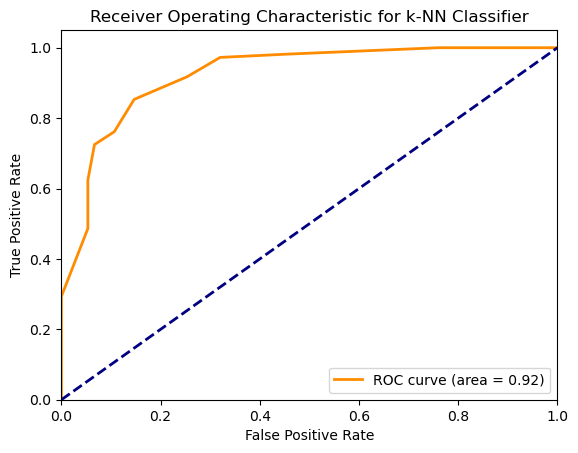

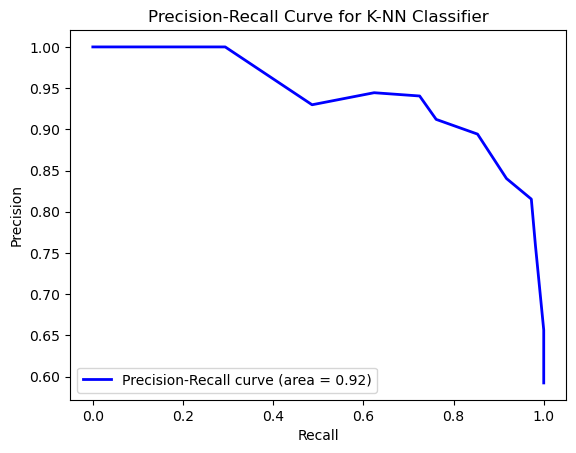

In [118]:
#Using k-NN for classification
#Use  GridSearchCV to find the best hyperparameters for k-NN

param_grid_knn = {'n_neighbors': [1,5,10]}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')

grid_search_knn.fit(X_train, y_train)
print(f"Best parameters for k-NN: {grid_search_knn.best_params_}")
print(f"Best score for k-NN: {grid_search_knn.best_score_}")

# Get the best k-NN model
best_knn_model = grid_search_knn.best_estimator_
# Make predictions on the test set
y_prob = best_knn_model.predict_proba(X_test)[:, 1]

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

# ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for k-NN Classifier')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for K-NN Classifier')
plt.legend(loc='lower left')
plt.show()


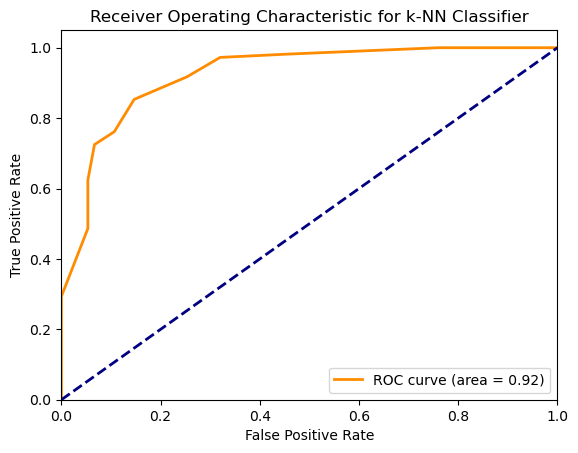

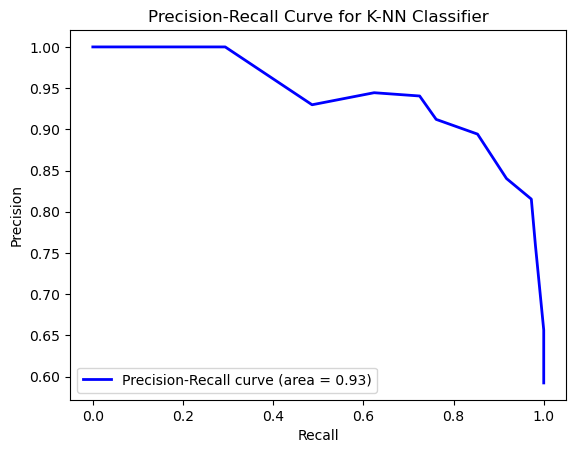

In [119]:
# k-NN Classifier tuning without GridSearch
AUROC = []
n_neighbors = []
accuracy = []
F1 = []

y_scores = None  # Initialize y_scores to None for ROC curve comparison
for n in [1, 5, 10]:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    y_prob = knn.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_prob)
    n_neighbors.append(n)
    accuracy.append(acc)
    F1.append(f1)
    AUROC.append(auroc)
    if y_scores is None or auroc > roc_auc_score(y_test, y_scores):
        y_scores = y_prob
knn_df = pd.DataFrame({
    'n_neighbors': n_neighbors,
    'accuracy': accuracy,
    'F1': F1,
    'AUROC': AUROC
})
best_knn = knn_df.loc[knn_df['AUROC'].idxmax()]


# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and PR area
precision, recall, _ = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for k-NN Classifier')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for K-NN Classifier')
plt.legend(loc='lower left')
plt.show()
